In [3]:
# Generic Matrix Factorization (without missing values)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [4]:
import pandas as pd

data = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
item_info = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1', usecols=[0, 1], names=['item_id', 'title'])
data = pd.merge(data, item_info, on='item_id')
data["item_id"].unique().shape

(1682,)

In [5]:
import pandas as pd

# Read in the data as a text file
with open("ml-1m/ratings.dat", "r") as f:
    data = f.readlines()

# Split each line into separate fields
data = [line.strip().split("::") for line in data]

# Convert the data to a DataFrame
df = pd.DataFrame(data, columns=["user_id", "item_id", "rating", "timestamp"])

# Remove the timestamp column
df = df.drop("timestamp", axis=1)

# Convert the rating column to integers
df["rating"] = df["rating"].astype(int)
df["item_id"] = df["item_id"].astype(int)
df["user_id"] = df["user_id"].astype(int)

# Print the resulting DataFrame
print(df.head())

data=df

data["user_id"].unique().shape
data["item_id"].unique().shape


   user_id  item_id  rating
0        1     1193       5
1        1      661       3
2        1      914       3
3        1     3408       4
4        1     2355       5


(3706,)

In [6]:
data

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [7]:
# data.drop(['title','timestamp'],axis=1)
# min(data['user_id'])
A = data.pivot(index='user_id', columns='item_id', values='rating')

A


item_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
A=data.pivot(index = 'user_id', columns='item_id', values='rating')


test_row = []
test_col = []
target_values = []

for r in range(0,A.shape[0]):
    row_list = A.iloc[r].values.tolist()
    bool_indices = list(np.isnan(row_list))

    nan_indices = []

    listt = [x for x in A]
    
    for i in range(0,len(bool_indices)):
        if bool_indices[i] == False:
            nan_indices.append((listt[i],i))
    
    
    random_int = np.random.choice(len(nan_indices),min(3,len(nan_indices)), replace=False)
    col_val = [nan_indices[i] for i in random_int]
    
    for i,k in col_val:
        test_row.append(r)
        target_values.append(A[i][r+1])
        A[i][r+1] = np.nan
        test_col.append(k)
       

print(target_values)



In [10]:
print(len(target_values))

18120


In [11]:


A = torch.tensor(A.values)
mask = ~torch.isnan(A)



In [12]:
df = data.pivot(index = 'user_id', columns='item_id', values='rating')
df.columns.values

array([   1,    2,    3, ..., 3950, 3951, 3952])

In [13]:
mask.sum()

tensor(982089)

In [14]:
#storing indices of each rating in the form of (user, movie)
users, movies = torch.where(mask)

ratings = A[mask]

# Store in PyTorch tensors
users = users.to(torch.int64)
movies = movies.to(torch.int64)
ratings = ratings.to(torch.float32)

In [15]:
# Now use matrix factorization to predict the ratings


# Create a class for the model

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=20):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.movie_factors = nn.Embedding(n_movies, n_factors)

    def forward(self, user, movie):

        valid_user = self.user_factors(user)
        valid_movie = self.movie_factors(movie)

        squashed_rating = torch.sigmoid((valid_user * valid_movie).sum(1))
        scaled_rating = (squashed_rating * 4.0) + 1.0

        return scaled_rating
     

    def return_result(self):
        return self.user_factors.weight.data, self.movie_factors.weight.data

In [16]:
# Fit the Matrix Factorization model

n_users, n_movies = A.shape

def factorize(k):
    model = MatrixFactorization(n_users, n_movies, k)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for i in range(1000):
        # Compute the loss1``
        pred = model.forward(users, movies)
        loss = F.mse_loss(pred, ratings)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        # if i % 100 == 0:
        #     print(loss.item())
    return model, loss.item()

In [ ]:
import matplotlib.pyplot as plt
k=[1,2,3,4,5,6,7,8,9,10,11,12]
loss=[]
for i in k:
    loss.append(factorize(i))
print(loss)

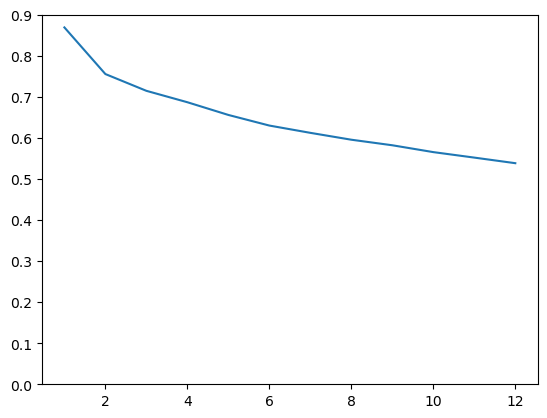

In [ ]:
plt.plot(k,loss)
plt.ylim(0,.9)
plt.show()

In [18]:
model = MatrixFactorization(n_users, n_movies, 3)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(1000):
    # Compute the loss
    pred = model.forward(users, movies)
    loss = F.mse_loss(pred, ratings)
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Backpropagate
    loss.backward()
    
    # Update the parameters
    optimizer.step()
    
    # Print the loss
    if i % 100 == 0:
        print(loss.item())

2.7858755588531494
1.471474051475525
0.8641321063041687
0.7710548043251038
0.7358052730560303
0.7196481823921204
0.7142279148101807
0.7124988436698914
0.7118222713470459
0.711502730846405


In [21]:

W,H = model.return_result()
result = torch.sigmoid(torch.matmul(W,H.T))*4.0 + 1.0

In [22]:
result
print(type(W))

<class 'torch.Tensor'>


In [23]:
pred = model.forward(torch.tensor(test_row),torch.tensor(test_col))
pred.shape
sum = 0
p = np.array(pred.tolist())
for i in p:
    try:
        sum+=i
    except: print(11111)

print(sum)


67219.58520257473


In [24]:
(target_values)
sum=0
for i in target_values:
    try:
        sum+=i

    except: print(11111)

print(sum)

67206.0


In [25]:
F.mse_loss(pred, torch.tensor(target_values))

tensor(0.8458, dtype=torch.float64, grad_fn=<MseLossBackward0>)

1 0.8804268836975098
2 0.8112123608589172
3 0.7950339317321777
4 0.8179070949554443
5 0.8296066522598267
6 0.8378099203109741
7 0.8711259961128235
8 0.9185578227043152
9 0.9343500733375549
10 0.9899535179138184


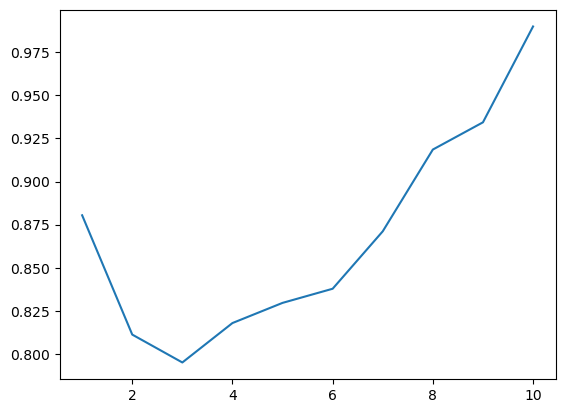

In [ ]:
k=[1,2,3,4,5,6,7,8,9,10]
loss=[]
models=[]
for i in k:
    model, loss_ = factorize(i)
    models.append(model)
    pred = model.forward(torch.tensor(test_row),torch.tensor(test_col))
    test_loss= F.mse_loss(pred, torch.tensor(target_values)).item()
    loss.append(test_loss)
    print(i, test_loss)
plt.plot(k,loss)

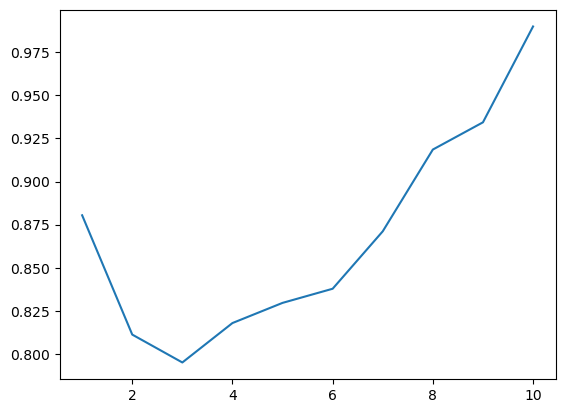

In [ ]:
plt.plot(k,loss)
plt.savefig('loss.png')

In [28]:
import pandas as pd

# read in the data
data = pd.read_csv("/home/rajeshv4u/Documents/movie_rec/ml-1m/users.dat", sep="::", engine="python",
                   names=["user_id", "gender", "age", "occupation_id", "time_stamp"])

# select columns of interest
user_data = data[["user_id", "gender", "age"]]


In [ ]:
user_data

,user_id,gender,age
0,1,F,1
1,2,M,56
2,3,M,25
3,4,M,45
4,5,M,25
...,...,...,...
6035,6036,F,25
6036,6037,F,45
6037,6038,F,56
6038,6039,F,45


In [ ]:
for i in range(len(user_data['gender'])):
    if user_data['gender'][i]=='M':
        user_data['gender'][i] = 1
    else:
        user_data['gender'][i] = 0

/tmp/ipykernel_80092/1027017772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['gender'][i] = 0
/tmp/ipykernel_80092/1027017772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['gender'][i] = 1


In [ ]:
user_data

,user_id,gender,age
0,1,0,1
1,2,1,56
2,3,1,25
3,4,1,45
4,5,1,25
...,...,...,...
6035,6036,0,25
6036,6037,0,45
6037,6038,0,56
6038,6039,0,45


In [ ]:
def k_nearest_neighbours(age, gender,df):
    if (gender == 'M') : gender = 1
    else: gender = 0

    age_ = np.array(df['age'])
    gender_ = np.array(df['gender'])

    distances = (np.square(age - age_) + np.square(gender - gender_))

    distances =  distances**0.5 

    sorted_df = pd.DataFrame({'user_id':[i+1 for i in range(df.shape[0])], 'distances' : distances})
    sorted_df = sorted_df.sort_values('distances', ascending=True)
    sorted_df = sorted_df[sorted_df['distances']<=5]
   
    return np.array(sorted_df['user_id'])




In [ ]:
arr = k_nearest_neighbours(25,'M', user_data)
n=30
random_choices = np.random.choice(arr, n, replace=False)